Tutorial: **Evoked Responses in the Visual Cortex**
===================================================

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tvb.simulator.lab import *
import numpy
import tvb.datatypes.projections as projections
from scipy import io

## Set up a Connectivity and its attributes.

In [3]:
conn = connectivity.Connectivity(load_default=True)
conn.speed = numpy.array([4.0])
conn_coupling = coupling.Linear(a=0.042)

## Set up a model.

In this configuration the topology of the phase portrait features a stable fixed point (a stable spiral) with a characteristics frequency of approximately 10Hz.
You can check it using the nice phase_plane_interactive tool ...

In [4]:
mod = models.Generic2dOscillator(a=-0.5, b=-15.0, c=0.0, d=0.02)

## Choose an integration scheme (noise or not?). 

Selecting a deterministic integration scheme allows you to observe very clearly the effect of stimulation-driven activity.
With a stochastic scheme, you may observe some neural reponses which are not due to stimulation but to noise fluctuations (uncontrolled reponses of the resting state).

In [5]:
hiss    = noise.Additive(nsig = numpy.array([0.015]))
heunint = integrators.HeunStochastic(dt=2**-6, noise=hiss)

## Build a Stimulus

In TVB's connectivity demo dataset region 35 and 36 represent areas V1 and V2 respectively in the left hemisphere. 

In [6]:
conn.configure()
nodes = [35, 36] 
stim_weights = numpy.zeros((conn.number_of_regions, 1))
stim_weights[nodes] = numpy.array([3.5, 0.0])[:, numpy.newaxis]
eqn_t = equations.PulseTrain()
eqn_t.parameters["onset"] = 500.0 # ms
eqn_t.parameters["tau"]   = 5.0   # ms
eqn_t.parameters["T"]     = 500.  # 0.002kHz repetition frequency

stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = conn, 
                                  weight = stim_weights)
    

## Record the ouput as:


* Temporal Averaged time-series. By default only the first state variable is recorded for the `Generic2dOscillator` model.

* EEG (FIXME. By default pr = projections.ProjectionRegionEEG() should do all the tricks)

In [7]:
pr = projections.ProjectionSurfaceEEG(load_default=True)
ss = sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt")
rm = region_mapping.RegionMapping(load_default=True)

In [8]:
rec = (monitors.TemporalAverage(period=1e3 / 2048.), 
       monitors.EEG(projection=pr, sensors=ss, region_mapping=rm, period=1e3/2048.)) 

## Create a `Simulator` instance. 

In [9]:
def config_sim(stim=None):
    sim = simulator.Simulator(model = mod, 
                          connectivity = conn,
                          coupling = conn_coupling, 
                          integrator = heunint, 
                          monitors = rec,
                          stimulus = stim)
                    
    sim.configure()
    return sim

## Create a `run` function to perform the simulation

In [10]:
def run_simulation(sim):
    
    LOG.info("Starting simulation...")
    #Perform the simulation
    tavg_data = []
    tavg_time = []
    eeg_data = []
    eeg_time = []
    for tavg, eeg in sim(simulation_length=2**10):
    # approx 4 sec
        if not tavg is None:
            tavg_time.append(tavg[0])
            tavg_data.append(tavg[1])
            
        if not eeg is None:
            eeg_time.append(eeg[0])
            eeg_data.append(eeg[1])
            
    LOG.info("Finished simulation.")
    return (tavg_data, tavg_time, eeg_data, eeg_time)

**Results**
==============
A. Activity in the absence of stimulation
------------------------------------------

In [11]:
sim = config_sim()
out = run_simulation(sim)

In [12]:
TAVG = numpy.array(out[0])
tt   = numpy.array(out[1])
EEG  = numpy.array(out[2])

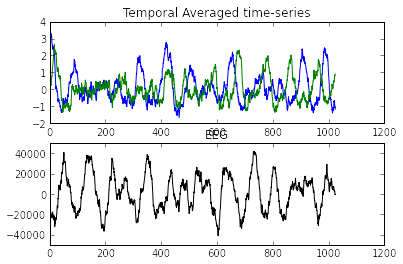

In [13]:
subplot(211)
plot(tt, TAVG[:, 0, nodes, 0])
title("Temporal Averaged time-series")

subplot(212)
plot(tt, EEG[:, 0, 60, 0], 'k')
title("EEG")

Figure 1: TAVG and EEG traces (0z) resting state

B. Stimulus-driven activity
----------------------------------------------------------

In [14]:
sim = config_sim(stim=stimulus)
stout = run_simulation(sim)

In [15]:
STAVG = numpy.array(stout[0])
stt   = numpy.array(stout[1])
SEEG  = numpy.array(stout[2])

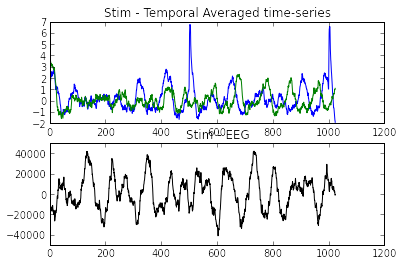

In [16]:
subplot(211)
plot(stt, STAVG[:, 0, nodes, 0])
title("Stim - Temporal Averaged time-series")

subplot(212)
plot(stt, SEEG[:, 0, 60, 0], 'k')
title("Stim - EEG") 

Figure 2: TAVG and EEG traces (0Z) under stimulation -- onset is @ 500 ms

#### If you want more ... Reproduce pretty pictures from the article (SanzLeon et al, 2013). Warning: Be patient ... 
--------------------------------------------------------------------------------------------------------------------
It takes about 10 min (two lengthy simulations + computing MSE estimates + pretty pictures)

In [17]:
run mse_analyse_region.py

Reproducible results and figures... Cool, huh? 